In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json

In [28]:
path_results = "test_results/19A_20A_19_Aug/"

In [40]:
def read_json(file_path):
    with open(file_path) as file:
        return json.loads(file.read())

In [41]:
f_dict = read_json(path_results + "f_word_dictionaries.json")

In [42]:
r_dict = read_json(path_results + "r_word_dictionaries.json")

In [43]:
def read_txt(file_path):
    data = None
    with open(file_path) as file:
        data = file.read()
    data = data.split("\n")
    data = data[:len(data) - 1]
    data = [float(i) for i in data]
    return data

In [44]:
#pretr_gen_loss = read_txt(path_results + "pretr_gen_loss.txt")
tr_gen_true_loss = read_txt(path_results + "tr_gen_true_loss.txt")
tr_gen_loss = read_txt(path_results + "tr_gen_loss.txt")
tr_disc_loss = read_txt(path_results + "tr_disc_loss.txt")

epochs = np.arange(0, 5)
epochs

array([0, 1, 2, 3, 4])

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

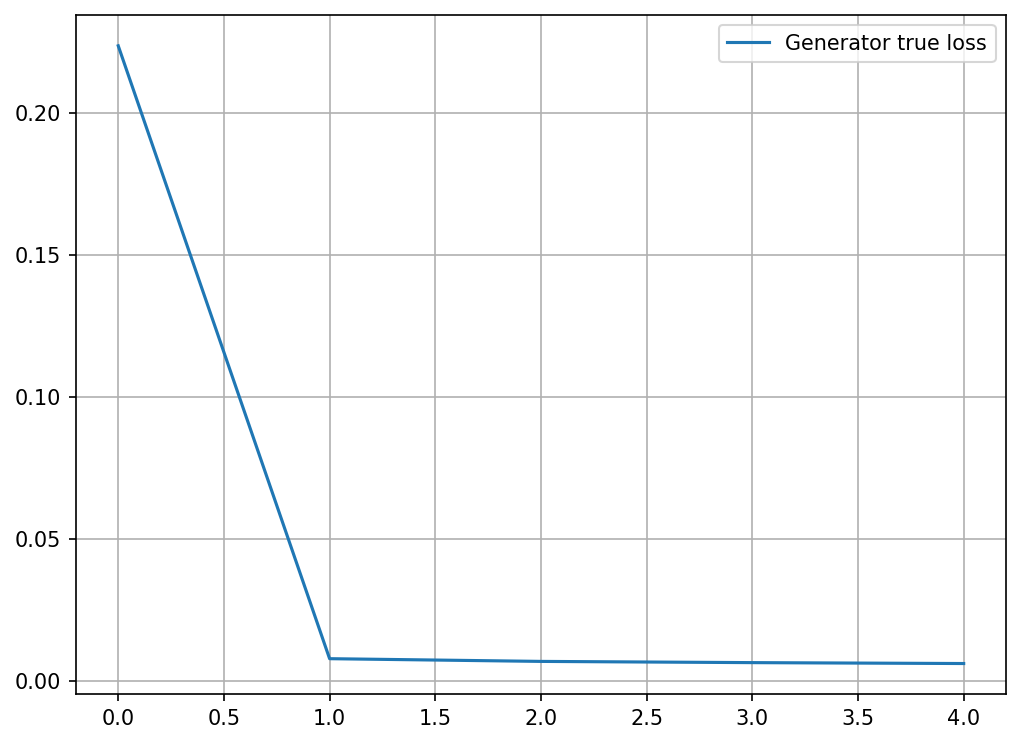

In [46]:
#dataframe = pd.DataFrame(list(zip(epochs, pretr_gen_loss, tr_gen_true_loss, tr_gen_loss, tr_disc_loss)), columns=["Epochs", "Pretrain gen loss","Tr gen true loss", "Tr gen loss", "Tr disc loss"])
plt.figure(figsize=(8, 6), dpi=150)

#plt.plot(epochs, pretr_gen_loss)
plt.plot(epochs, tr_gen_true_loss)
#plt.plot(epochs, tr_gen_loss)
#plt.plot(epochs, tr_disc_loss)
#plt.ylim(-0.5, 1.25)
plt.legend(["Generator true loss"])
plt.grid(True)
plt.show()

In [47]:
df_true_pred = pd.read_csv(path_results + "true_predicted_df.csv")
df_true_pred

,19A,20A,Generated
0,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
1,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
2,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
3,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
4,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
...,...,...,...
21217,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
21218,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
21219,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."
21220,"13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,...","13,14,22,14,11,22,11,11,15,11,22,17,17,6,5,22,..."


In [97]:
cols = list(df_true_pred.columns)
max_rows = 5000
A19_20A = dict()
A19_C_20A = dict()
A20_C_20A = dict()

def write_dict(path, dic):
    dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    with open(path, "w") as f:
        f.write(json.dumps(dic))

for index, row in df_true_pred.iterrows():
    true_x = row[cols[0]].split(",")
    true_y = row[cols[1]].split(",")
    pred_y = row[cols[2]].split(",")
    space = 1
    for i in range(len(true_x)):
        first = true_x[i:i+space]
        sec = true_y[i:i+space]
        third = pred_y[i:i+space]

        first_aa = [f_dict[j] for j in first]
        sec_aa = [f_dict[j] for j in sec]
        third_aa = [f_dict[j] for j in third]

        intersection_f_s = set(sec_aa).difference(set(first_aa))
        intersection_f_t = set(third_aa).difference(set(first_aa))
        intersection_s_t = set(third_aa).difference(set(sec_aa))
        
        first_mut = first_aa[0]
        second_mut = sec_aa[0]
        third_mut = third_aa[0]
        
        if first_mut != "X" and second_mut != "X":

            if len(intersection_f_s) > 0:
                #print("Mutations: 19A - 20A")
                #print(intersection_f_s)
                #print(i+1, first_aa, sec_aa)
                key = "{}>{}>{}".format(first_mut, str(i+1), second_mut)
                #print(key)
                if key not in A19_20A:
                    A19_20A[key] = 0
                A19_20A[key] += 1
                #print("-------------")
        
        if first_mut != "X" and third_mut != "X":
        
            if len(intersection_f_t) > 0:
                #print("Mutations: 19A - Children of 20A")
                #print(intersection_f_t)
                #print(i+1, first_aa, third_aa)
                key = "{}>{}>{}".format(first_mut, str(i+1), third_mut)
                #print(key)
                if key not in A19_C_20A:
                    A19_C_20A[key] = 0
                A19_C_20A[key] += 1
                #print("-------------")
        
        if second_mut != "X" and third_mut != "X":
            
            if len(intersection_s_t) > 0:
                #print("Mutations: 20A - Children of 20A")
                #print(intersection_s_t)
                #print(i+1, sec_aa, third_aa)
                key = "{}>{}>{}".format(second_mut, str(i+1), third_mut)
                #print(key)
                if key not in A20_C_20A:
                    A20_C_20A[key] = 0
                A20_C_20A[key] += 1
                #print("-------------")
                
    #if index == max_rows:
    #    break

write_dict(path_results + "A19_20A.json", A19_20A)
write_dict(path_results + "A19_C_20A.json", A19_C_20A)
write_dict(path_results + "A20_C_20A.json", A20_C_20A)

In [118]:
keys_A19_20A = list(A19_20A.keys())
keys_A19_C_20A = list(A19_C_20A.keys())
keys_A20_C_20A = list(A20_C_20A.keys())

In [120]:
mut_A19_C_20A__A19_20A = list(set(keys_A19_C_20A).difference(keys_A19_20A))
mut_A19_C_20A__A19_20A

[]

In [123]:
mut_A20_C_20A__A19_20A = list(set(keys_A20_C_20A).difference(keys_A19_20A))

In [129]:
import pandas as pd

c_20A = ["20B", "20C", "20E (EU1)", "21A (Delta)", "21B (Kappa)", "21D (Eta)"]

df = pd.read_csv("data/generated_files/sample_clade_mutation.csv", sep=",")

c_mut_list = list()

for c in c_20A:
    u_list = list()
    df_mut = df[df["Nextstrain clades"] == c]["Mutations"]
    df_mut_list = df_mut.tolist()
    for item in df_mut_list:
        mut = item.split(",")
        u_list.extend(mut)
    u_list = list(set(u_list))
    c_mut_list.extend(u_list)

In [132]:
for novel_mut in mut_A20_C_20A__A19_20A:
    mut_pos = novel_mut.split(">")[1]
    for original_mut in c_mut_list:
        if mut_pos in original_mut:
            print(mut_pos, novel_mut, original_mut)
            print("-----")

76 R>76>T L176F
-----
76 R>76>T G769V
-----
76 R>76>T L176-
-----
76 R>76>T T676A
-----
76 R>76>T V976I
-----
76 R>76>T T76I
-----
76 R>76>T T1076I
-----
69 S>69>H G769V
-----
69 S>69>H H69-
-----
69 S>69>H H69Y
-----
69 S>69>H I1169V
-----
69 S>69>H H69-
-----
69 S>69>H S698L
-----
69 S>69>H A694V
-----
69 S>69>H H69-
-----
647 S>647>A A647S
-----
647 S>647>A A647S
-----
689 R>689>S S689I
-----
681 H>681>P P681H
-----
681 H>681>P P681R
-----
681 H>681>P R681P
-----
681 H>681>P R681H
-----
59 Y>59>F S459Y
-----
59 Y>59>F T859I
-----
59 Y>59>F D1259H
-----
59 Y>59>F D1259Y
-----
174 S>174>P P174S
-----
98 F>98>S S982A
-----
98 F>98>S S98F
-----
98 F>98>S S698L
-----
98 F>98>S Q498L
-----
98 F>98>S S98F
-----
1247 S>1247>C C1247F
-----
1247 S>1247>C C1247S
-----
1203 I>1203>L L1203F
-----
75 K>75>G N751D
-----
75 K>75>G F175-
-----
75 K>75>G A575S
-----
75 K>75>G Q675H
-----
75 K>75>G Q675R
-----
75 K>75>G Q675H
-----
75 K>75>G G75V
-----
1263 L>1263>P P1263L
-----
1263 L>1263>P P1263T
-

In [154]:
from Levenshtein import distance as levenshtein_distance
import numpy as np

parent_child = list()
child_20A = list()

for index, row in df_true_pred.iterrows():
    par = row["19A"]
    child = row["20A"]
    gen = row["Generated"]
    
    l_dist_par_child = levenshtein_distance(par, child)
    parent_child.append(l_dist_par_child)
    
    l_dist_child_generated = levenshtein_distance(child, gen)
    child_20A.append(l_dist_child_generated)

In [155]:
mean_par_child = np.mean(parent_child)
mean_par_child

37.217651493732916

In [156]:
mean_child_20A = np.mean(child_20A)
mean_child_20A

24.603147676939024